In [ ]:
import hashlib   # 用于哈希计算
import os     # 提供与操作系统交互的功能
import requests  # 发送HTTP请求下载文件
import tarfile   # 解压文件
import zipfile

- URL(Uniform Resource Locator)，指向应该特定的网页、文件或其他资源
  - `协议://域名（或IP地址）/路径`
- `download`：从指定的`url`下载文件，并保存在`folder`中
    - `os.path.exists`检查文件夹是否存在，返回布尔值
    - `os.makedirs`创建指定的文件夹
    - `url.split('/')[-1]`将URL按斜杠分割，并取最后一个元素（文件名）
    - `fname`文件的保存路径
    - 如果匹配，说明文件完整，直接返回文件路径`fname`，**避免重新下载**
    - 如果文件不存在或校验未通过，程序将下载文件
- `download_extract `：用于下载并解压`.zip`或`.tar/.gz`文件，并且返回文件路径
    - `name`数据集名称（在`DATA_HUB`中的键）

In [ ]:
DATA_HUB = dict()
# 定义一个基础的URL地址，所有的数据集文件将以在URL作为开头
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(url, folder='../data', sha1_hash=None):
    if not os.path.exists(folder):
        os.makedirs(folder)
    fname = os.path.join(folder, url.split('/')[-1])# 完整文件路径

    # 如果匹配，说明文件完整，直接返回文件路径`fname`，避免重新下载
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()                       # 创建一个 SHA-1 哈希对象
        with open(fname, 'rb') as f:                # 以二进制模式打开文件
            while True:
                data = f.read(1048576)                     # 以每次 1 MB 的块大小读取文件
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname

    # 如果文件不存在或校验未通过，程序将下载文件
    print(f'downloading {fname} from {url}')
    r = requests.get(url, stream=True, timeout=10)  # 发送 HTTP GET 请求下载文件
    with open(fname, 'wb') as f:                    # 二进制写模式打开文件 fname
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)               # 获取文件路径的目录部分
    data_dir, ext = os.path.splitext(fname)         # 将文件名和扩展名分开
    if ext == '.zip':
        with zipfile.ZipFile(fname, 'r') as z:      # 以只读模式打开 .zip 文件
            z.extractall(base_dir)                  # 将 .zip 文件解压到 base_dir 目录
    elif ext in ('.tar', '.gz'):
        with tarfile.open(fname, 'r') as t:
            t.extractall(base_dir)
    else:
        raise ValueError('只有zip/tar文件可以被解压缩')
    return os.path.join(base_dir, folder) if folder else data_dir

In [ ]:
!pip install d2l

In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision

from torch import nn
from d2l import torch as d2l

**获取并组织数据集**
- 提供的是：包含前1000个训练图像和5个随机测试图像的数据集的小规模样本
- `../data/cifar-10/`：假设存在完整的CIFAR-10数据集的路径
- `d2l.DATA_HUB['cifar10_tiny']`：添加了数据集的下载信息

- **先挂载Google Drive**
  - **确保可以访问`/content/drive/My Drive`**
  - 否则下载的都是在Colab的*临时文件系统*中
- 文件已经下载到了网盘中
  -
  ```
  data_dir = '/content/drive/My Drive/ColabData/cifar10_tiny'
  os.path.join(data_dir, 'trainLabels.csv'
  ```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir_dirve = '/content/drive/My Drive/ColabData/'
drive_data_dir = '/content/drive/My Drive/ColabData/cifar10_tiny'

d2l.DATA_HUB['cifar10_tiny'] = (
  d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
  '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd'
)

demo = True

if demo:
  data_dir= d2l.download_extract('cifar10_tiny')
else:
  data_dir = '../data/cifar-10/'

if not os.path.exists(drive_data_dir):
  shutil.move(data_dir, drive_data_dir)

#### 整理数据集

**读取CSV文件中的标签**
- CSV文件，每行的数据用逗号分隔，文件的第一行是标题行

In [ ]:
# 直接`pd.read_csv(fname)`得到是一个dataframe

def read_csv_labels(fname):
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

data_dir = '/content/drive/My Drive/ColabData/cifar10_tiny'

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('训练样本：', len(labels))
print('类别', len(set(labels.values())))
print(list(labels.items())[:20])

训练样本： 1000
类别 10
[('1', 'frog'), ('2', 'truck'), ('3', 'truck'), ('4', 'deer'), ('5', 'automobile'), ('6', 'automobile'), ('7', 'bird'), ('8', 'horse'), ('9', 'ship'), ('10', 'cat'), ('11', 'deer'), ('12', 'horse'), ('13', 'horse'), ('14', 'bird'), ('15', 'truck'), ('16', 'truck'), ('17', 'truck'), ('18', 'cat'), ('19', 'bird'), ('20', 'frog')]


**将验证集从原始的训练集中拆分出来**
- `valid_ratio`是验证集中的样本数与原始训练集中样本数之比
- 将验证集的样本数设置为统一的`n*valid_ratio`，是为了确保类别平衡，挺高泛化性
  - 验证集的样本数是按**最少类别的样本数**和**统一比例**`valid_ratio`来设置的
- 得到三个文件夹
  - `train_valid`
  - `valid`
  - `test`

- 没有使用交叉验证，太贵了
- `shutil`：Python的标准库模块，提供文件操作相关的实用函数
  - `shutil.copy`：将文件从源位置复制到目标位置（输入参数都是*路径*）
- ` n = collections.Counter(labels.values()).most_common()[-1][1]`
  - `collections.Counter`**统计每个类别的样本数**，生成一个字典，键是类别，值是该类别的样本数
  - `.most_common()`返回也按类别出现**频次降序排列的列表**
    - `most_common(n)`会返回前`n`个最常见的元素及其出现次数
- `os.listdir()`列出制定目录中的所有文件和文件夹的名称
- `train_file.split('.')[0]`去掉文件的扩展名，仅保留文件名
  - `lables[]`使用字典`labels`获取文件名对应的类别标签
- `os.path.join(data_dir, 'train_valid_test', 'train_valid', label)`：构建目标路径，在`train_valid_test/train_valid`文件夹中按标签分类
- `.get(label, 0)`可以避免当字典中缺少某个键引发的`KeyError`
  - 如果字典`label_count`中存在键`label`，则返回该键对应的值
  - 如果字典中不存在`label`，则返回默认值`0`，而不是抛出错误

In [ ]:
def copyfile(filename, target_dir):
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
  n = collections.Counter(labels.values()).most_common()[-1][1]
  # 验证集中每个类别的样本数
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_file.split('.')[0]]
    fname = os.path.join(data_dir, 'train', train_file)
    copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
      label_count[label] = label_count.get(label, 0) + 1
    else:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
  return n_valid_per_label

**在预测期间整理测试集，以方便读取**

In [ ]:
def reorg_test(data_dir):
  for test_file in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(
        os.path.join(data_dir, 'test', test_file),
        os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')
    )

**调用前面定义的函数**

In [ ]:
def reorg_cifar10_data(data_dir, valid_ratio):
  labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
  reorg_train_valid(data_dir, labels, valid_ratio)
  reorg_test(data_dir)

In [ ]:
# 因为数据已经下载，之后都不用再运行
demo = True

batch_size=32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

#### 图像增广

In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1., 1.)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
    )
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
    )
])

#### 读取数据集

**读取由原始图像组成的数据集**
- **`torch.datasets.ImageFolder(root=, transform)`**
  - 从文件夹中加载图像数据，特别适用于**有特定目录结构**的**图像**数据集
  - **自动分类**：自动将子文件夹名称作为类别标签，并生成标签索引
  - **轻松访问数据**：直接返回图像和标签，支持使用**`DataLoader`**进行批量处理
  - **可与变换一起使用**：支持图像变换，便于进行数据增强或预处理

In [ ]:
train_ds, train_valid_ds = [
  torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train
  )
  for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [
  torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test
  )
  for folder in ['valid', 'test']
]

**指定上面定义的所有图像增广操作**

In [ ]:
train_iter, train_valid_iter = [
  torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True
  )
  for dataset in [train_ds, train_valid_ds]
]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

**看一下这些iter，print一个出来试试？？**

#### 定义模型、训练函数

In [ ]:
def get_net():
  num_classes = 10
  net = d2l.resnet18(num_classes, 3) # RGB三通道
  return net

loss = nn.CrossEntropyLoss(reduction='none')

使用**lr衰减**——**统计模型**上
- `torch.optim.SGD`中的参数`momentum`通过在每次更新时添加上一次更新的一个比例来帮助“加速”梯度下降
  - 用于加速梯度下降并减小震荡
  - 如`momentum=0.9`表示每次更新时保留90%的上一次的更新方向

使用**学习率衰减**——**优化模型**上
- **`torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)`：学习率调度器**
  - 用于在训练过程中按指定的补偿降低学习率
  - 通过动态调整学习率，可以更好地控制模型的训练过程，有助于提高训练效果和收敛速度
- 常用的还有余退火的学习率**`torch.optim.lr_scheduler.CosinAnnealingLR(optimizer, T_max, eta_min）`**
  - 平滑的学习率变化，更好的收敛

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net = train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = (pred.argmax(dim=1) == y).sum()
  return train_loss_sum, train_acc_sum

def evcaluate_accuracy_gpu

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
  trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
  schedular = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  num_batches, timer = len(train_iter), d2l.Timer()
  legend = ['train loss', 'train acc']
  if valid_iter is not None:
    legend.append('valid acc')
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    net.train()
    metric = d2l.d2l.Accumulator(3)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0])
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
         animator.add(
            epoch + (i + 1) / num_batches,
            (metric[0] / metric[2], metric[1] / metric[2], None)
         )
    if valid_iter is not None:
      valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
      animator.add(epoch + 1, (None, None, valid_acc))
    schedular.step()
  measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
  if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
  print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

**训练和验证模型**

train loss 0.544, train acc 0.812, valid acc 0.552
642.1 examples/sec on [device(type='cuda', index=0)]


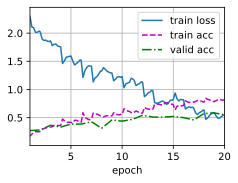

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 2e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

#### 对**完整的数据集**重新训练模型并对测试集进行分类
- `y_hat.argmax(dim=1)`：返回每个样本的最大概率**索引**
- `list.extend`添加多个元素
- `.sort(key=None, reverse=None)`
  - `key`用于指定排序的基准函数
  - **就地排序**
  - **`sorted`**保留原列表不变，返回一个新的已排序的列表
- `pd.DataFrame`创建一个DataFrame
- `train_valid_ds.classes[x]`将预测的类别索引`x`转换为对应的类别名称
  -
- `df.to_csv('name.csv', index=False)`保存为CSV文件，但是不包含索引

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 2e-4
lr_period, lr_decay = 4, 0.9

net, preds = get_net(), []
train(net, train_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X, y in test_iter:
  y_hat = net(X.to(devices[0]))
  preds.extend(y_hat.argmax(dim=1).tpye(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x:str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x:train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

**按字符串排序？？**是什么意思，为啥能确保提交文件中的`id`顺序与文件系统中的字典序一致？？

- `y_hat.argmax(dim=1)`取出对应的类

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/content/drive/My Drive/ColabData/cifar10_tiny/train_valid_test/train_valid/truck/764.png'>

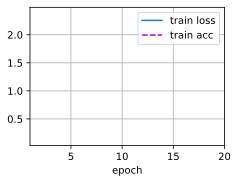

In [ ]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

**想想如何使用fine-tuning??**  
**不用数据增强结果会怎样？**